In [1]:
from ast import literal_eval
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import scipy.sparse as sprs

import warnings
warnings.filterwarnings('ignore')

In [2]:
base_path = './data/Restaurant_TijuanaRestaurant'

item_metadata = pd.read_csv(f'{base_path}/item_metadata.csv')
item_metadata.set_index('id', inplace=True)

context_metadata = pd.read_csv(f'{base_path}/context_metadata.csv')
context_metadata.set_index('id', inplace=True)

ratings = pd.read_csv(f'{base_path}/ratings.csv', converters={"context factors": literal_eval})

users = ratings['user'].unique()
cfs = context_metadata.index
items = item_metadata.index

nodes = []
nodes.extend(users)
nodes.extend(cfs)
nodes.extend(items)

# Statistics

In [3]:
print('# Ratings \t\t=', len(ratings))
print()
print('# Users \t\t=', len(users))
print('# Items \t\t=', len(items))
print()
print('# Context factors \t=', len(cfs))
print()
print('----')
print('Total nodes \t\t=', len(nodes))

# Ratings 		= 1382

# Users 		= 44
# Items 		= 40

# Context factors 	= 6

----
Total nodes 		= 90


# Knowledge Graph

In [4]:
G = nx.Graph()
G.add_nodes_from(nodes)

# Add edges
for _, rating in ratings.iterrows():
    if rating['rating'] > 4:
        user = rating['user']
        item = rating['item']
        cfs_ = rating['context factors']
                
        for cf in cfs_:
            # User -> Context factors
            G.add_edge(user, cf)
            
            # Context factors -> Item
            G.add_edge(cf, item)

# Visualization

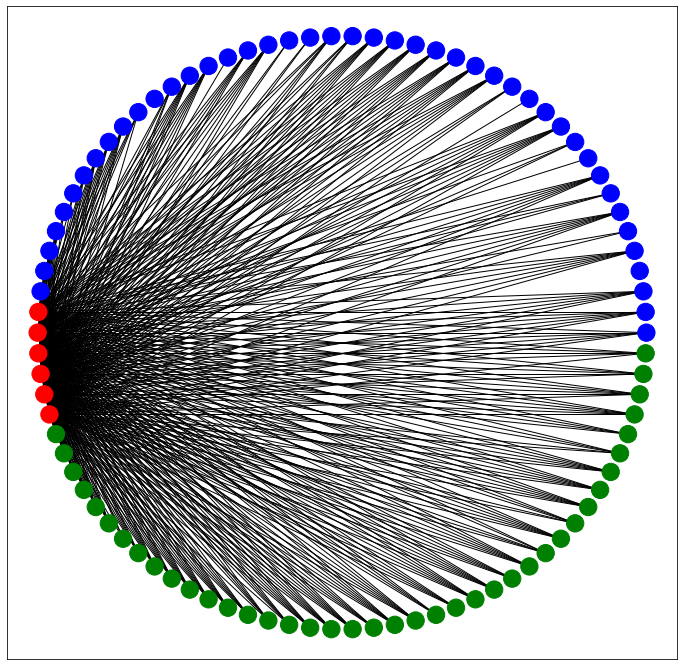

In [5]:
c = []
for node in G:
    if node in users:
        c.append('blue')
    elif node in cfs:
        c.append('red')
    elif node in items:
        c.append('green')
    else:
        c.append('black')

        
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

nx.draw_networkx(G, pos=nx.circular_layout(G), node_color=c, with_labels=False, ax=ax)

In [6]:
edges_per_item = sorted([(node, len(list(nx.all_neighbors(G, node)))) for node in items], key=lambda n: n[1], reverse=True)

for idx, n_edges in edges_per_item:
    name = item_metadata['name'].loc[idx]
    print(f'[{n_edges}] {idx} - {name}')

[6] http://example.org/Restaurant#2 -  Big Boy (Agua caliente)  
[6] http://example.org/Restaurant#4 -  Café de la Flor  
[6] http://example.org/Restaurant#5 -  Carls Jr (Otay) 
[6] http://example.org/Restaurant#6 -  Carnitas Uruapan (La mesa) 
[6] http://example.org/Restaurant#9 -  Cosco (Fuente de sodas) Zona Rio 
[6] http://example.org/Restaurant#10 -  Daruma (Calz Tecnologico) 
[6] http://example.org/Restaurant#11 -  Dominos Pizza (Calz Tecnologico)  
[6] http://example.org/Restaurant#12 -  El Mazateño (Calz Tecnológico) 
[6] http://example.org/Restaurant#13 -  El porton (Blv Insurgentes) 
[6] http://example.org/Restaurant#17 -  Kentucky Fried Chicken (Calle na) 
[6] http://example.org/Restaurant#18 -  La Casa del Mole ( Zona Rio) 
[6] http://example.org/Restaurant#19 -  La Leña  
[6] http://example.org/Restaurant#21 -  La Torta Plaza (Zona Rio)  
[6] http://example.org/Restaurant#22 -  La Espadaña  
[6] http://example.org/Restaurant#25 -  Mc Donals (Zona Rio) 
[6] http://example.o

# Recommendations

### No personalization

In [7]:
pr = nx.pagerank(G, alpha=0.3, tol=0.001)

recommendations = sorted([(item, p) for item, p in pr.items() if item in items], key=lambda n: n[1], reverse=True)

for idx, p in recommendations:
    name = item_metadata['name'].loc[idx]
    print(f'[{p}] {idx} - {name}')

[0.00893213207288622] http://example.org/Restaurant#2 -  Big Boy (Agua caliente)  
[0.00893213207288622] http://example.org/Restaurant#4 -  Café de la Flor  
[0.00893213207288622] http://example.org/Restaurant#5 -  Carls Jr (Otay) 
[0.00893213207288622] http://example.org/Restaurant#6 -  Carnitas Uruapan (La mesa) 
[0.00893213207288622] http://example.org/Restaurant#9 -  Cosco (Fuente de sodas) Zona Rio 
[0.00893213207288622] http://example.org/Restaurant#10 -  Daruma (Calz Tecnologico) 
[0.00893213207288622] http://example.org/Restaurant#11 -  Dominos Pizza (Calz Tecnologico)  
[0.00893213207288622] http://example.org/Restaurant#12 -  El Mazateño (Calz Tecnológico) 
[0.00893213207288622] http://example.org/Restaurant#13 -  El porton (Blv Insurgentes) 
[0.00893213207288622] http://example.org/Restaurant#17 -  Kentucky Fried Chicken (Calle na) 
[0.00893213207288622] http://example.org/Restaurant#18 -  La Casa del Mole ( Zona Rio) 
[0.00893213207288622] http://example.org/Restaurant#19 -

### Personalization (user-driven)

In [8]:
user = 'http://example.org/User#1'
uitems = ratings.loc[ratings['user'] == user]['item'].unique()

personalization = {}
for node in nodes:
    if node in uitems:
        personalization[node] = 0.8
    else:
        personalization[node] = 0.2

In [9]:
pr = nx.pagerank(G, alpha=0.8, personalization=personalization, tol=0.001)

recommendations = sorted([(item, p) for item, p in pr.items() if item in items and item not in uitems], key=lambda n: n[1], reverse=True)      

for idx, p in recommendations:
    name = item_metadata['name'].loc[idx]
    print(f'[{p}] {idx} - {name}')

[0.006376118289745443] http://example.org/Restaurant#6 -  Carnitas Uruapan (La mesa) 
[0.006376118289745443] http://example.org/Restaurant#13 -  El porton (Blv Insurgentes) 
[0.006376118289745443] http://example.org/Restaurant#17 -  Kentucky Fried Chicken (Calle na) 
[0.006376118289745443] http://example.org/Restaurant#18 -  La Casa del Mole ( Zona Rio) 
[0.006376118289745443] http://example.org/Restaurant#25 -  Mc Donals (Zona Rio) 
[0.006376118289745443] http://example.org/Restaurant#26 -  Pampas Do Brasil  
[0.006376118289745443] http://example.org/Restaurant#37 -  Tortas La Vuelta  
[0.006376118289745443] http://example.org/Restaurant#38 -  Tortas Wash Movile (CalzTecnológico) 
[0.00555277037529565] http://example.org/Restaurant#39 -  Villa Saverios  
[0.005551396077221748] http://example.org/Restaurant#8 -  Cheripan (Zona Rio)  
[0.005551396077221748] http://example.org/Restaurant#14 -  El Rodeo (La mesa)  
[0.005551396077221748] http://example.org/Restaurant#20 -  La Querencia  


### Personalization (context-driven)

In [10]:
user = 'http://example.org/User#0'
uitems = ratings.loc[ratings['user'] == user]['item'].unique()

contexts = ['http://example.org/ContextFactor#s3']

personalization = {}
for node in nodes:
    if node in uitems:
        personalization[node] = 0.5
    elif node in contexts:
        personalization[node] = 0.3
    else:
        personalization[node] = 0.2

In [11]:
pr = nx.pagerank(G, alpha=0.3, personalization=personalization, tol=0.001)

recommendations = sorted([(item, p) for item, p in pr.items() if item in items and item not in uitems], key=lambda n: n[1], reverse=True)      

for idx, p in recommendations:
    name = item_metadata['name'].loc[idx]
    print(f'[{p}] {idx} - {name}')

[0.007665891823860033] http://example.org/Restaurant#2 -  Big Boy (Agua caliente)  
[0.007665891823860033] http://example.org/Restaurant#4 -  Café de la Flor  
[0.007665891823860033] http://example.org/Restaurant#6 -  Carnitas Uruapan (La mesa) 
[0.007665891823860033] http://example.org/Restaurant#10 -  Daruma (Calz Tecnologico) 
[0.007665891823860033] http://example.org/Restaurant#11 -  Dominos Pizza (Calz Tecnologico)  
[0.007665891823860033] http://example.org/Restaurant#13 -  El porton (Blv Insurgentes) 
[0.007665891823860033] http://example.org/Restaurant#18 -  La Casa del Mole ( Zona Rio) 
[0.007665891823860033] http://example.org/Restaurant#21 -  La Torta Plaza (Zona Rio)  
[0.007665891823860033] http://example.org/Restaurant#26 -  Pampas Do Brasil  
[0.007665891823860033] http://example.org/Restaurant#30 -  Ricardo’s (Zona Centro) 
[0.007665891823860033] http://example.org/Restaurant#32 -  Sanborns (Zona Rio)  
[0.007665891823860033] http://example.org/Restaurant#33 -  Sirloin 

In [12]:
import itertools
from sklearn.model_selection import KFold

from evaluation.metrics import MetricFactory, MetricType
from recommenders.ppr import PersonalizedPageRank, NetworkxPersonalizedPageRank

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(ratings)

metrics = ['precision', 'recall', 'f1', 'ndcg']
cutoffs = [5, 10]
measures = [f'{m}@{c}' for m, c in itertools.product(metrics, cutoffs)]

global_scores = {}
for m in measures:
    global_scores[m] = []

i = 0
for train_idx, test_idx in kf.split(ratings):
    print(f'--- [Fold {i}] ---')
    
    df_train = ratings.iloc[train_idx]
    r = NetworkxPersonalizedPageRank(df_train, verbose=False)
    r.set_personalization(0.5, 0.3)
    
    scores = {}
    for m in measures:
        scores[m] = []
    
    df_test = ratings.iloc[test_idx]
    df_test['context factors'] = df_test['context factors'].transform(lambda x: ' '.join(x))
    # Drop irrelevant ratings
#     df_test = df_test.drop(df_test[df_test['rating'] < 4].index)
    
    for uid, cid in df_test.groupby(['user', 'context factors']).groups.keys():
        # Run PersonalizedPageRank for user and context
        r.run(uid, cid.split(' '), alpha=0.3, tol=0.001)
        
        previously_rated_items = df_train.loc[(df_train['user'] == uid) & (df_train['context factors'] == ' '.join(cid))]['item'].unique()
        candidate_items = df_train['item'].unique()
        
        # Rank all candidate items that have not been previously rated
        ranking = []
        for iid in candidate_items:
            if iid not in previously_rated_items:
                rank = r.predict(uid, cid.split(' '), iid)
                ranking.append((iid, rank))
        ranking = sorted(ranking, key=lambda i: i[1], reverse=True)
        
        if len(ranking) == 0:  # No recommended items exist for this user and context
            continue
        
        recommendations = [iid for iid, pr in ranking]
        truth = df_test.loc[(df_test['user'] == uid) & (df_test['context factors'] == cid)]['item'].unique()
        
        for m in measures:
            m_ = m.split('@')
            m_name = m_[0]
            m_topn = int(m_[1])

            metric = MetricFactory().get(MetricType.reverse_lookup(m_name))
            score = metric.calculate(recommendations, truth, m_topn)
            scores[m].append(score)
    
    for k, v in scores.items():
        mean = sum(v) / len(v)
        scores[k] = mean
        global_scores[k].append(mean)
    print(scores)
    
    i += 1

print(f'--- [Total] ---')
for k, v in global_scores.items():
    global_scores[k] = sum(v) / len(v)
print(global_scores)

--- [Fold 0] ---
{'precision@5': 0.017187499999999998, 'precision@10': 0.0421875, 'recall@5': 0.06315104166666666, 'recall@10': 0.251171875, 'f1@5': 0.026010664682539687, 'f1@10': 0.06941151296620046, 'ndcg@5': 0.0340082435489291, 'ndcg@10': 0.10187679194114137}
--- [Fold 1] ---
{'precision@5': 0.027419354838709685, 'precision@10': 0.054838709677419314, 'recall@5': 0.09489247311827957, 'recall@10': 0.3102150537634409, 'f1@5': 0.039976958525345614, 'f1@10': 0.08951693467822495, 'ndcg@5': 0.052663669679335154, 'ndcg@10': 0.13367958624316353}
--- [Fold 2] ---
{'precision@5': 0.03252032520325204, 'precision@10': 0.05121951219512192, 'recall@5': 0.1043360433604336, 'recall@10': 0.28008130081300814, 'f1@5': 0.047360949799974184, 'f1@10': 0.08349617861812982, 'ndcg@5': 0.06058490008680134, 'ndcg@10': 0.12731720444362726}
--- [Fold 3] ---
{'precision@5': 0.022222222222222223, 'precision@10': 0.047008547008547, 'recall@5': 0.07336182336182336, 'recall@10': 0.28831908831908826, 'f1@5': 0.0329331

In [13]:
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(ratings)

metrics = ['precision', 'recall', 'f1', 'ndcg']
cutoffs = [5, 10]
measures = [f'{m}@{c}' for m, c in itertools.product(metrics, cutoffs)]

global_scores = {}
for m in measures:
    global_scores[m] = []

i = 0
for train_idx, test_idx in kf.split(ratings):
    print(f'--- [Fold {i}] ---')
    
    df_train = ratings.iloc[train_idx]
    r = PersonalizedPageRank(df_train, verbose=False)
    r.set_personalization(0.5, 0.3)
    
    scores = {}
    for m in measures:
        scores[m] = []
    
    df_test = ratings.iloc[test_idx]
    df_test['context factors'] = df_test['context factors'].transform(lambda x: ' '.join(x))
    # Drop irrelevant ratings
#     df_test = df_test.drop(df_test[df_test['rating'] < 4].index)
    
    for uid, cid in df_test.groupby(['user', 'context factors']).groups.keys():
        recommendations = r.predict(uid, cid.split(' '))
        
        truth = df_test.loc[(df_test['user'] == uid) & (df_test['context factors'] == cid)]['item'].unique()
        # truth = [i for i in truth2 if i in r.items] # Don't allow items not present in the training set
        
        for m in measures:
            m_ = m.split('@')
            m_name = m_[0]
            m_topn = int(m_[1])

            metric = MetricFactory().get(MetricType.reverse_lookup(m_name))
            score = metric.calculate(recommendations, truth, m_topn)
            scores[m].append(score)
    
    for k, v in scores.items():
        mean = sum(v) / len(v)
        scores[k] = mean
        global_scores[k].append(mean)
    print(scores)
    
    i += 1

print(f'--- [Total] ---')
for k, v in global_scores.items():
    global_scores[k] = sum(v) / len(v)
print(global_scores)

--- [Fold 0] ---
{'precision@5': 0.043076923076923096, 'precision@10': 0.03384615384615385, 'recall@5': 0.17307692307692307, 'recall@10': 0.27692307692307694, 'f1@5': 0.06776556776556776, 'f1@10': 0.05967365967365967, 'ndcg@5': 0.10182654484846729, 'ndcg@10': 0.1357603444572067}
--- [Fold 1] ---
{'precision@5': 0.05625000000000003, 'precision@10': 0.04296874999999997, 'recall@5': 0.21484375, 'recall@10': 0.33984375, 'f1@5': 0.08742559523809527, 'f1@10': 0.07540246212121209, 'ndcg@5': 0.12882986319098724, 'ndcg@10': 0.17163111593812932}
--- [Fold 2] ---
{'precision@5': 0.04687500000000002, 'precision@10': 0.04140624999999998, 'recall@5': 0.18359375, 'recall@10': 0.3515625, 'f1@5': 0.07328869047619048, 'f1@10': 0.07339015151515148, 'ndcg@5': 0.1646323300988204, 'ndcg@10': 0.21972074102415817}
--- [Fold 3] ---
{'precision@5': 0.025185185185185192, 'precision@10': 0.040740740740740716, 'recall@5': 0.09259259259259259, 'recall@10': 0.3333333333333333, 'f1@5': 0.038800705467372125, 'f1@10': 